<div style="border-left: 5px solid green; padding: 10px; background-color:rgb(224, 247, 206);">
    <b>⚡️ Information:</b>
    Yihan's customized unet experiment
</div>

### Step 0 - Set & Check available memory

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]  # Set limit to 8GB
        )
        print("Limited GPU memory usage to 8GB")
    except RuntimeError as e:
        print(e)

Limited GPU memory usage to 8GB


2025-03-09 00:43:40.283679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 00:43:40.288199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 00:43:40.288719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for i, gpu in enumerate(gpus):
        device_name = f"GPU:{i}"  # Properly format the device name
        details = tf.config.experimental.get_memory_info(device_name)
        print(f"GPU: {device_name}")
        print(f"Current Memory Usage: {details['current']} bytes")
        print(f"Peak Memory Usage: {details['peak']} bytes")
else:
    print("No GPU devices found.")

for gpu in gpus:
    print(f"Memory growth for {gpu}: {tf.config.experimental.get_memory_growth(gpu)}")

GPU: GPU:0
Current Memory Usage: 0 bytes
Peak Memory Usage: 0 bytes
Memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): None


2025-03-09 00:43:41.717711: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 00:43:41.718177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 00:43:41.718735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 00:43:41.719197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Step 1 - Set up environment

In [5]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

#### Specify all paths and global params

In [6]:
# Specify a sample path (here we will take the first patient of the Training dataset)
brats_index = 'BraTS-GLI-00077-000'
brats_sample_path = f'../brain_tumor_seg/data/raw_data/GLI_train/{brats_index}/{brats_index}-'

# Specify the root data path of training data
data_path_GLI_train_dir = f'../brain_tumor_seg/data/raw_data/GLI_train'


# Define selected slices range
VOLUME_START_AT = 60 
VOLUME_SLICES = 75 

# For DataGenerator
IMG_SIZE = 128
LOSS_FUNCTION = "categorical_crossentropy"

### Not a Step - Explore data

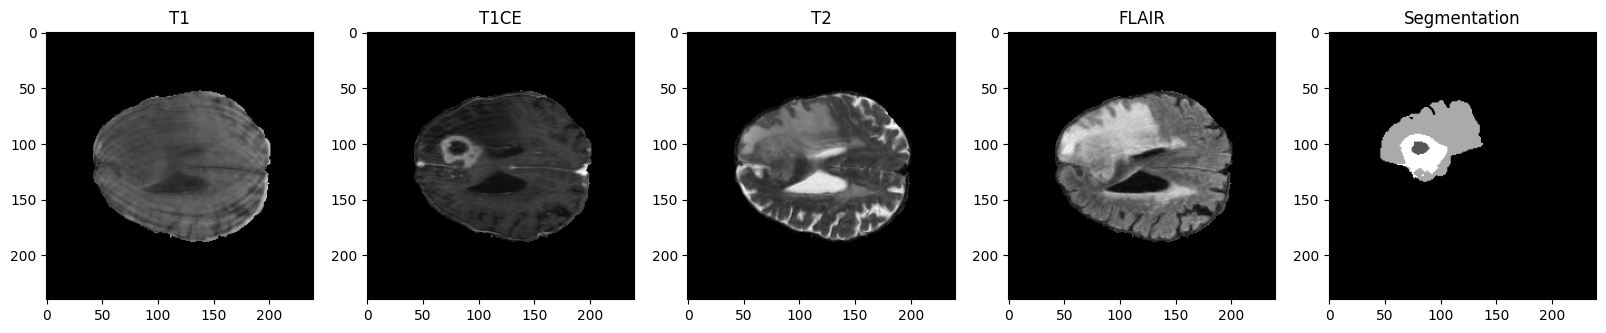

In [26]:
# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img_sample=nib.load(brats_sample_path + 't1n.nii.gz')
t1ce_img_sample=nib.load(brats_sample_path + 't1c.nii.gz')
t2_img_sample=nib.load(brats_sample_path + 't2w.nii.gz')
flair_img_sample=nib.load(brats_sample_path + 't2f.nii.gz')
seg_img_sample=nib.load(brats_sample_path + 'seg.nii.gz')

# Get the image data
t1_data_sample = t1_img_sample.get_fdata()
t1ce_data_sample = t1ce_img_sample.get_fdata()
t2_data_sample = t2_img_sample.get_fdata()
flair_data_sample = flair_img_sample.get_fdata()
seg_data_sample = seg_img_sample.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data_sample[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data_sample[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data_sample[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data_sample[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data_sample[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.savefig(f'./plt/seg_classes_{brats_index}.png', dpi=300)
plt.show()

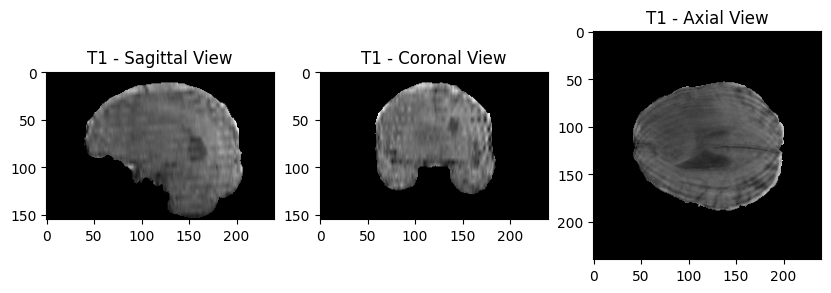

In [27]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data_sample[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data_sample[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data_sample[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

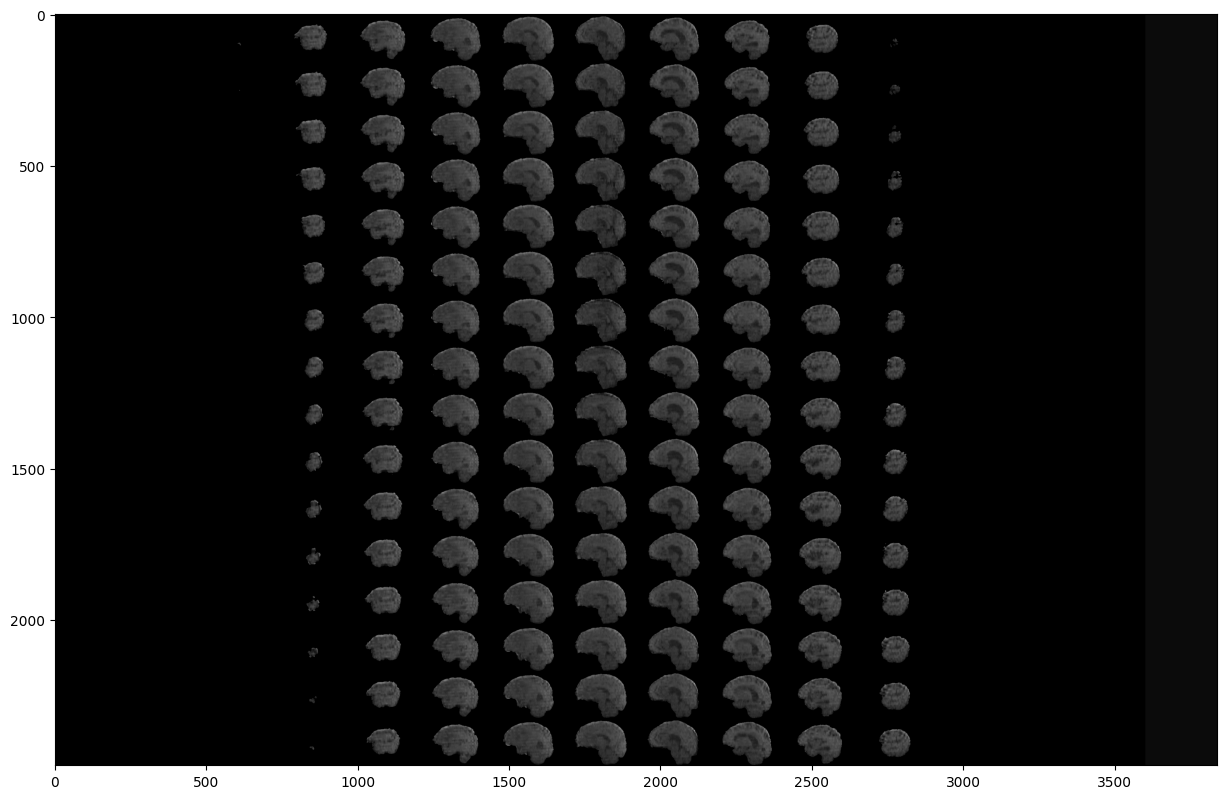

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data_sample[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

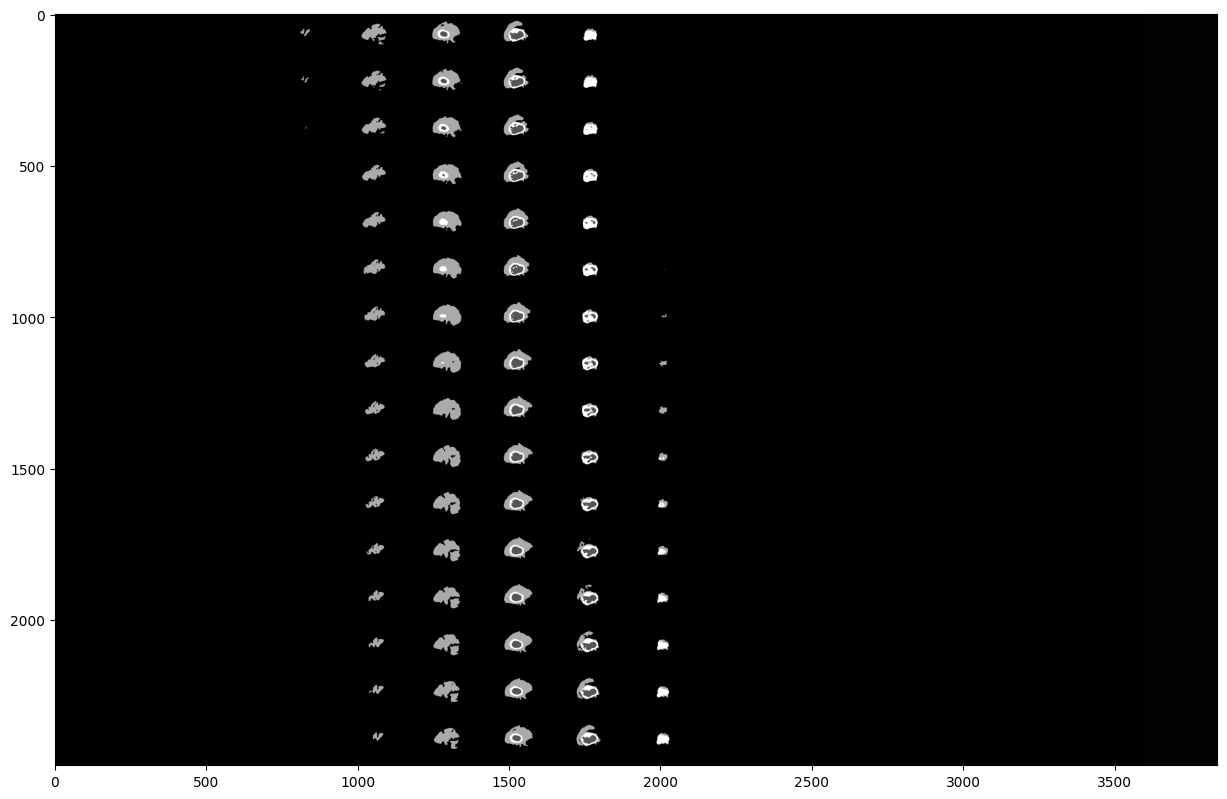

In [29]:
# Display all slices of a segmentation
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data_sample[:,:,:]), 90, resize=True), cmap ='gray')

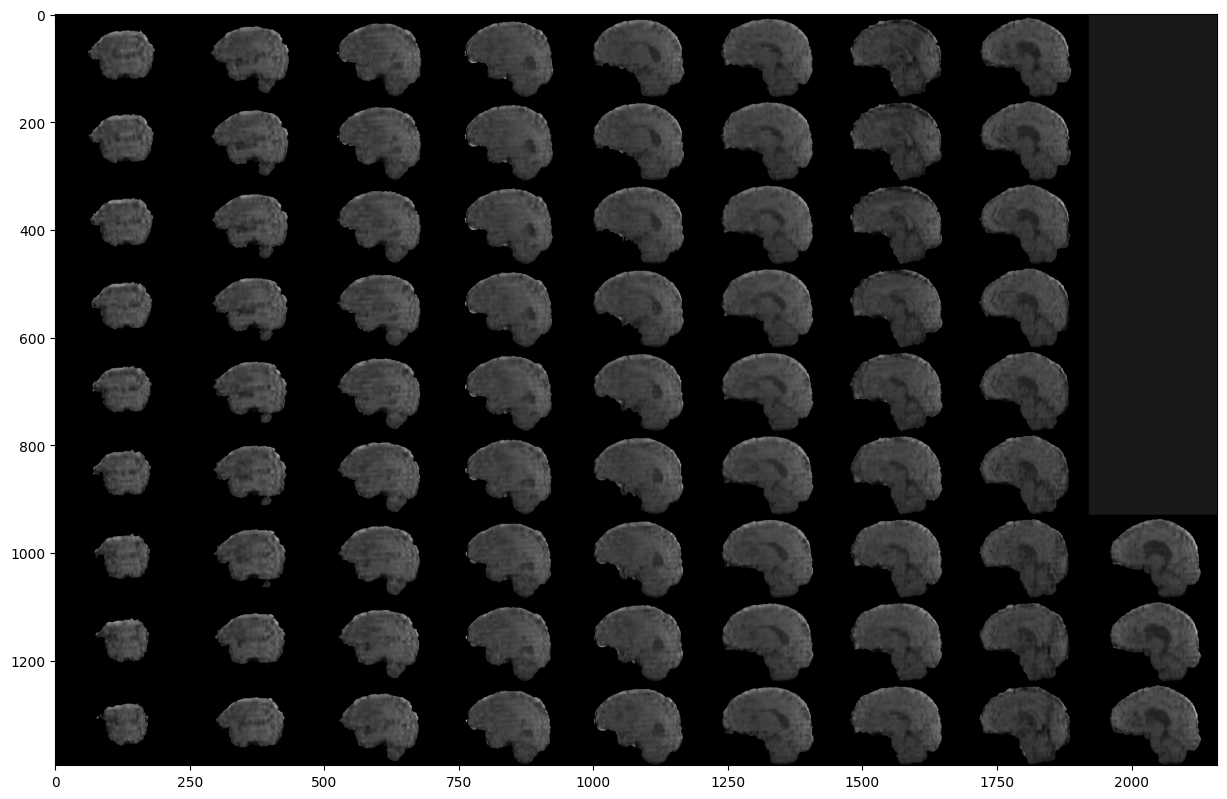

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data_sample[60:135,:,:]), 90, resize=True), cmap ='gray')

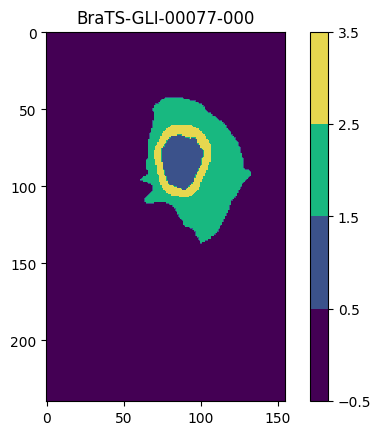

In [34]:
# Plot a segmantation
some_seg_img = nib.load(f'{brats_sample_path}seg.nii.gz').get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.title(brats_index)
plt.colorbar()

In [32]:
seg_samples = [os.path.join(data_path_GLI_train_dir, sample, f"{sample}-seg.nii.gz") for sample in os.listdir(data_path_GLI_train_dir) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img_sample = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img_sample)
    nb_unique_values = len(np.unique(seg_img_sample))
    
    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 3.]


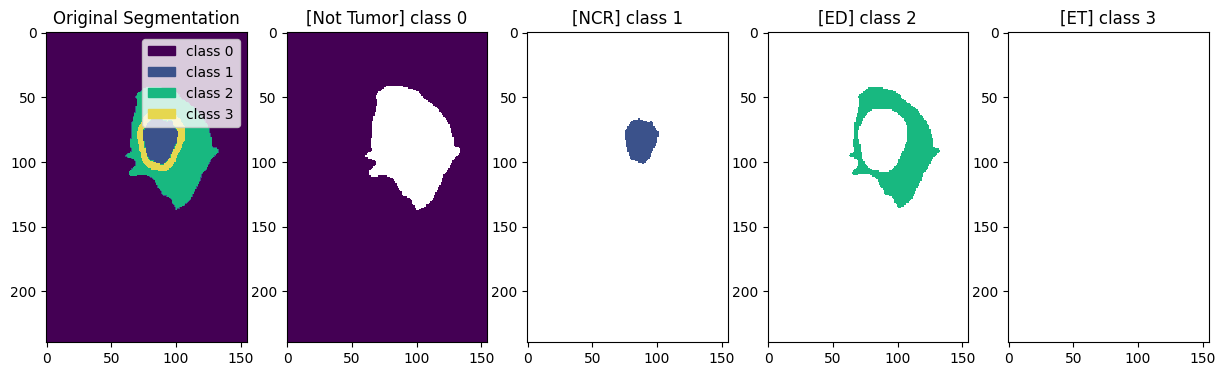

In [33]:
# Deletion of class 0
seg_0 = some_seg_img.astype(float).copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.astype(float).copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.astype(float).copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.astype(float).copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('[Not Tumor] class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('[NCR] class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('[ED] class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('[ET] class 3')

# Save the figure to a file
plt.savefig('segmentation_classes.png', dpi=300)  # Saves the image as 'segmentation_classes.png'

plt.show()

In [34]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(f'distribution of 4 classes: {counts}')

distribution of 4 classes: [8730782   20623  139678   36917]


In [35]:
# Modality shape
print(f'modality shape: {t1_data_sample.shape}')

# Segmentation shape
print(f'segmentation shape: {seg_data_sample.shape}')

modality shape: (240, 240, 155)
segmentation shape: (240, 240, 155)


### Step 2 - Load images and parameters

In [15]:
# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
all_datas = os.listdir(data_path_GLI_train_dir)
print("Number of samples:", len(all_datas))

Number of samples: 1251


In [16]:
# Split the dataset into train and validation sets
datas_train, datas_val = train_test_split(all_datas, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set 
datas_train, datas_test = train_test_split(datas_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(datas_train)}")
print(f"Validation length: {len(datas_val)}")
print(f"Test length: {len(datas_test)}")

Train length: 850
Validation length: 251
Test length: 150


In [38]:
pip show keras tensorflow # type: ignore

Name: keras
Version: 2.7.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /home/cbel/Desktop/YIHAN/venv/lib/python3.8/site-packages
Requires: 
Required-by: tensorflow
---
Name: tensorflow
Version: 2.7.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/cbel/Desktop/YIHAN/venv/lib/python3.8/site-packages
Requires: flatbuffers, google-pasta, protobuf, astunparse, keras, h5py, tensorflow-estimator, six, opt-einsum, typing-extensions, wrapt, tensorflow-io-gcs-filesystem, keras-preprocessing, numpy, libclang, gast, termcolor, tensorboard, absl-py, wheel, grpcio
Required-by: 


Note: you may need to restart the kernel to use updated packages.


In [17]:
import tensorflow as tf
print("===============================")
print(f'tensorflow version: {tf.__version__}')  # Should print 2.7.0
print(f'is built with CUDA: {tf.test.is_built_with_cuda()}')  # Should return True
print(f'GPU details: {tf.config.list_physical_devices("GPU")}')  # Should show GPU details

# Check if TensorFlow can detect a GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

print("===============================")

tensorflow version: 2.7.0
is built with CUDA: True
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.


### Step 3 - Set up training compoenents

**When generating `DataGenerator`**:
- We use a data generator to be able to process and send our data to our neural network (since all our images cannot be stored in memory at once).
- For each epoch (single pass of the entire training dataset through a neural network), the model will receive 250 samples (those contained in our training dataset).
- For each sample, the model will have to analyze 150 slices (since there are two modalities, and 75(VOLUME_SLICES) selected slices for both of them), received in a (128, 128) shape, as an X array of a (128, 128, 75, 2) shape. This array will be provided with the ground truth segmentation of the patient, which will be One-Hot encoded and will then have a (75, 128, 128, 4) shape.

#### 3 - 1: DataGenerator

In [18]:
from tensorflow.keras import layers, models

# DataGenerator from Rastislav's notebook, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net

class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):
            
            # Get path of each RMI modality and the segmentation
            data_path = os.path.join(data_path_GLI_train_dir, i, i)
            t1ce_path = data_path + '-t1c.nii.gz'
            flair_path = data_path + '-t2f.nii.gz'
            seg_path = data_path + '-seg.nii.gz'
            #t1_path = sample_path + '_t1.nii.gz'
            #t2_path = sample_path + '_t2.nii.gz'
            
            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()
            #t1 = nib.load(t1_paths).get_fdata()
            #t2 = nib.load(t2_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                    
        # Masks / Segmentations
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/np.max(X), Y
        
training_generator = DataGenerator(datas_train)
valid_generator = DataGenerator(datas_val)
test_generator = DataGenerator(datas_test)

#### 3 -2: U-Net model

In [19]:
# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

#### 3 - 3: Metrics

In [20]:
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

########################### my customized metrics ###########################

def sensibility(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    # Calculate the sensibility
    sensibility = 1 - (false_positives / (true_positives + possible_positives + K.epsilon()))
    # Check for NaN or Inf values and return NaN if True
    sensibility = tf.where(tf.math.is_nan(sensibility) | tf.math.is_inf(sensibility),
                           tf.constant(float('NaN')),
                           sensibility)
    return sensibility


def jaccard(y_true, y_pred):
    # True positives, false positives, false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    # Calculate Jaccard index
    denominator = true_positives + false_positives + false_negatives + K.epsilon()  # Add epsilon to avoid division by zero
    result = true_positives / denominator
    # Handle NaN or Inf cases
    result = K.switch(K.is_inf(result) | K.is_nan(result), K.constant(float('NaN')), result)
    return result


# Hausdorff distance (approximation for use in Keras)
def hausdorff(y_true, y_pred):
    # Flatten the coordinates of the true and predicted segmentation masks
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    # Compute the Euclidean distance between every pair of points
    dist_matrix = K.square(y_true_flat - y_pred_flat)
    # Get the maximum distance in both directions (directed Hausdorff)
    directed_hausdorff_1 = K.max(dist_matrix, axis=1)  # From y_true to y_pred
    directed_hausdorff_2 = K.max(dist_matrix, axis=0)  # From y_pred to y_true
    # Take the maximum of both directed Hausdorff distances
    hausdorff_dist = K.maximum(directed_hausdorff_1, directed_hausdorff_2)
    # Handle NaN or Inf values by replacing them with NaN (if needed)
    hausdorff_dist = K.switch(K.is_inf(hausdorff_dist) | K.is_nan(hausdorff_dist), K.constant(float('NaN')), hausdorff_dist)
    return hausdorff_dist

#### 3 - 4: Check the GPU and memory status

In [21]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for i, gpu in enumerate(gpus):
        device_name = f"GPU:{i}"  # Properly format the device name
        details = tf.config.experimental.get_memory_info(device_name)
        print(f"GPU: {device_name}")
        print(f"Current Memory Usage: {details['current']} bytes")
        print(f"Peak Memory Usage: {details['peak']} bytes")
else:
    print("No GPU devices found.")

for gpu in gpus:
    print(f"Memory growth for {gpu}: {tf.config.experimental.get_memory_growth(gpu)}")

GPU: GPU:0
Current Memory Usage: 0 bytes
Peak Memory Usage: 0 bytes
Memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): None


#### 3 - 5: Build the model

In [22]:
from keras import Input
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss=LOSS_FUNCTION, optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity ] )

#### 3 - 6: Set up callbacks

Callbacks are functions that can be executed during the training process. 

We will use three callbacks:

- **ReduceLROnPlateau**: This callback reduces the learning rate when a metric has stopped improving (validation loss here). The learning rate is reduced by a factor of 0.2, the patience is set to 2 epochs, and the minimum learning rate is set to 0.000001.

- **ModelCheckpoint**: Saves the best model weights (model that has obtained the lowest validation loss during the different epochs). Saving a model allows us to reuse it later or to share it, without having to retrain it from scratch. This will save us time and resources!

- **CSVLogger**: Add metrics to a CSV file, which is named *training.log* (parameter `append` is set to `False` so the file is overwritten if it already exists). 

In [24]:
from datetime import datetime
import os

# Generate timestamp for filenames
start_train_timestamp = datetime.now().strftime("%b-%d_%H-%M-%S")

model_dir = f'./model_{start_train_timestamp}'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Model dir {model_dir} created.")
else:
    print(f"Model dir {model_dir} existed.")

# Define file paths with timestamps
training_log_filename = f"{model_dir}/training-{start_train_timestamp}.log"
model_checkpoint_path = f"{model_dir}/model_epoch{{epoch:02d}}-val_loss{{val_loss:.6f}}_{start_train_timestamp}.m5"

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
    
    keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True),

    CSVLogger(training_log_filename, separator=',', append=False)  # Save logs with timestamp
]

Model dir ./model_Mar-09_00-59-34 created.


### Step 4 - Train & Save the model

In [ ]:
epochs = 100
steps_per_epoch = len(datas_train)

print(f'epochs: {epochs}')
print(f'steps_per_epoch: {steps_per_epoch}\n----------')

model.fit(training_generator,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks,
          validation_data=valid_generator)

epochs: 100
steps_per_epoch: 850
----------
Epoch 1/100


2025-03-08 09:52:09.167686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


850/850 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9810 - mean_io_u_1: 0.6525 - dice_coef: 0.2786 - precision: 0.9807 - sensitivity: 0.9785 - specificity: 0.9940
Epoch 00001: val_loss improved from inf to 0.06949, saving model to ./model_Mar-08_09-52-06/model_epoch01-val_loss0.069491_Mar-08_09-52-06.m5
850/850 [==============================] - 253s 291ms/step - loss: 0.0856 - accuracy: 0.9810 - mean_io_u_1: 0.6525 - dice_coef: 0.2786 - precision: 0.9807 - sensitivity: 0.9785 - specificity: 0.9940 - val_loss: 0.0695 - val_accuracy: 0.9821 - val_mean_io_u_1: 0.7328 - val_dice_coef: 0.2817 - val_precision: 0.9820 - val_sensitivity: 0.9820 - val_specificity: 0.9940 - lr: 0.0010
Epoch 2/100
850/850 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9813 - mean_io_u_1: 0.5455 - dice_coef: 0.2959 - precision: 0.9816 - sensitivity: 0.9805 - specificity: 0.9939
Epoch 00002: val_loss improved from 0.06949 to 0.06583, saving model to ./model_Mar-

#### Plot the training process

In [10]:
training_log_filename = f"./model_Mar-08_09-52-06/training-Mar-08_09-52-06.log"

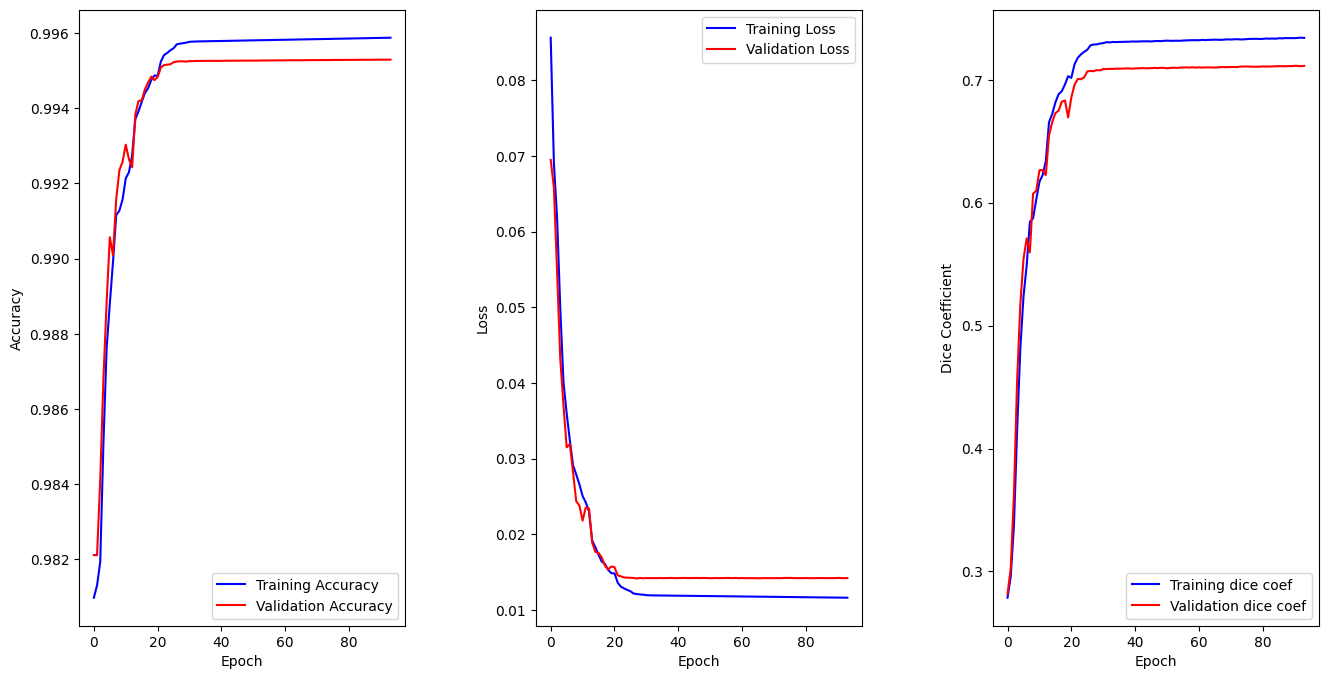

In [13]:
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv(training_log_filename, sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
# fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

# axs[3].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
# axs[3].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
# axs[3].set_xlabel('Epoch')
# axs[3].set_ylabel('Mean IOU')
# axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)
# plt.savefig(f'./plt/{model_dir.split("/")[-1]}.png', dpi=300)
plt.savefig(f'./plt/training-Mar-08_09-52-06.png', dpi=300)
plt.show()

### Step 5 - Predict

In [32]:
# Compile a model and load our saved weights
from tensorflow.keras import Input

IMG_SIZE = 128

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

TRAINED_MODEL = 'model_epoch28-val_loss0.014139_Mar-08_09-52-06.m5'

best_saved_model.load_weights(f'./model_Mar-08_09-52-06/{TRAINED_MODEL}')

In [30]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '-t1c.nii.gz'
    flair_path = sample_path + '-t2f.nii.gz'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'
            
    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    
    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    # Send our images to the CNN model and return predicted segmentation 
    return model.predict(X/np.max(X), verbose=1)

In [29]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)
    print(f'random_sample: {random_sample}')
    
    # Get path of this patient
    random_sample_path = os.path.join(data_path_GLI_train_dir, random_sample, random_sample)
    print(f'random_sample_path: {random_sample_path}')
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '-seg.nii.gz'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')
    
    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')
    
    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')
    
    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')
    
    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

random_sample: BraTS-GLI-01072-000
random_sample_path: ../brain_tumor_seg/data/raw_data/GLI_train/BraTS-GLI-01072-000/BraTS-GLI-01072-000
3/3 [==============================] - 1s 196ms/step
Patient number:  BraTS-GLI-01072-000


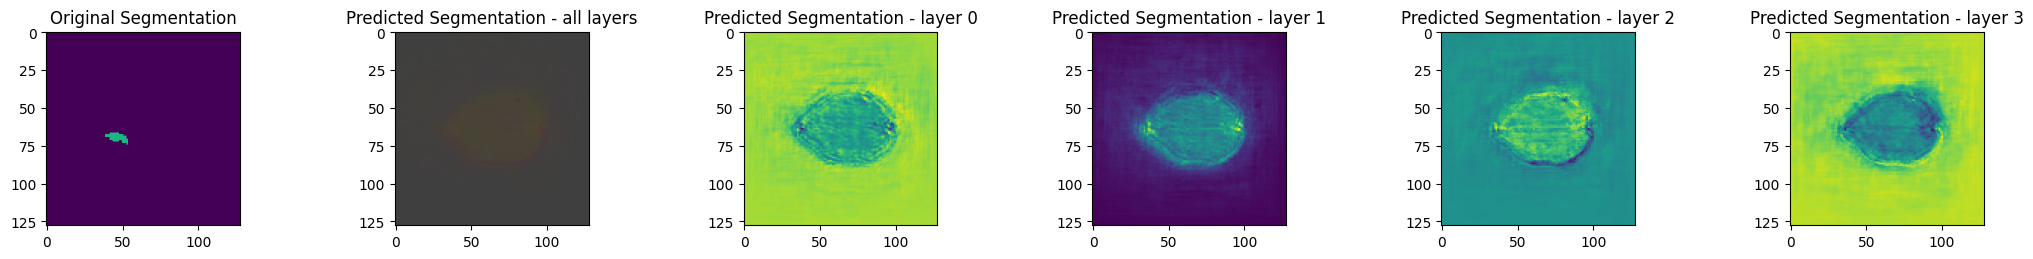

In [35]:
show_predicted_segmentations(datas_test, 60, cmap, norm)

random_sample: BraTS-GLI-00537-000
random_sample_path: ../brain_tumor_seg/data/raw_data/GLI_train/BraTS-GLI-00537-000/BraTS-GLI-00537-000
3/3 [==============================] - 0s 13ms/step
Patient number:  BraTS-GLI-00537-000


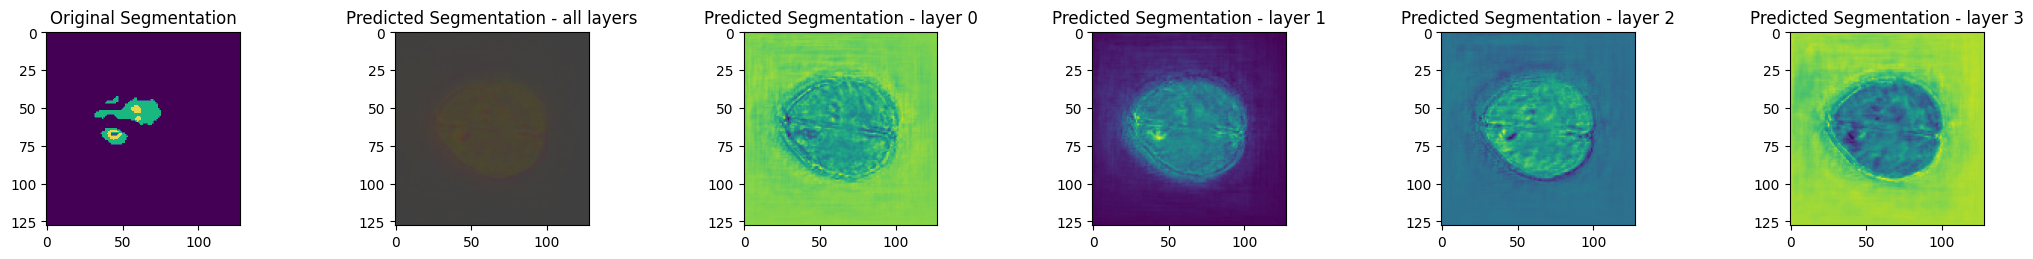

In [36]:
show_predicted_segmentations(datas_test, 50, cmap, norm)

random_sample: BraTS-GLI-00274-000
random_sample_path: ../brain_tumor_seg/data/raw_data/GLI_train/BraTS-GLI-00274-000/BraTS-GLI-00274-000
3/3 [==============================] - 0s 13ms/step
Patient number:  BraTS-GLI-00274-000


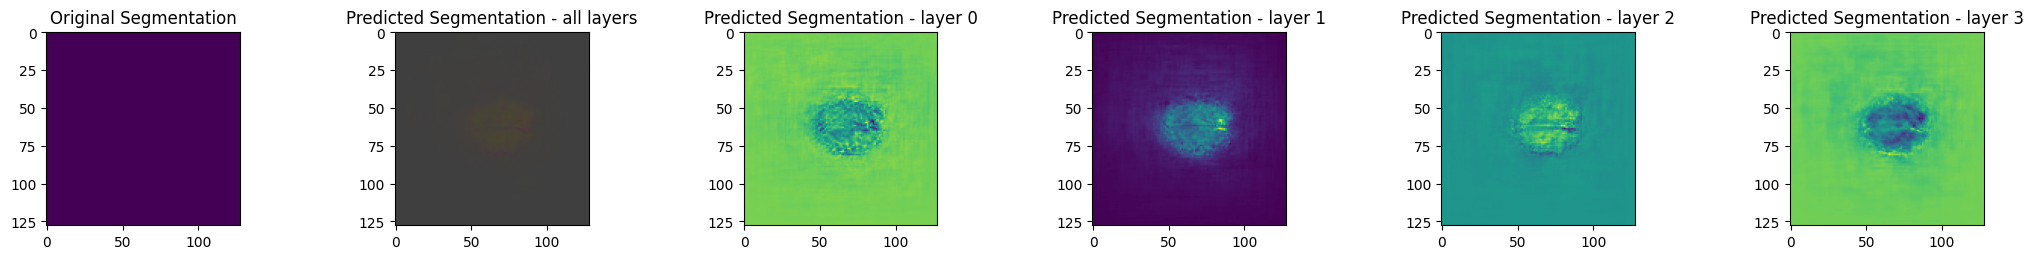

In [37]:
show_predicted_segmentations(datas_test, 70, cmap, norm)

In [39]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):
    
    # Get path of this patient
    sample_path = os.path.join(data_path_GLI_train_dir, sample, sample)
    
    # Predict patient's segmentation
    predicted_seg = predict_segmentation(sample_path)
   
    # Load patient's original segmentation (Ground truth)
    seg_path = sample_path + '-seg.nii.gz'
    seg = nib.load(seg_path).get_fdata()
    
    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # Fix 4 to 3 to have the same values as in the predicted segmentation, and then same colors
    seg[seg==4] = 3
    
    # Remove background layer (0) from original segmentation
    seg[seg==0] = np.nan
    
    # Post-processing
    # Get indexes for each class of the highest probability pixels. Array will then contain only [0 1 2 3] instead of probabilities
    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]

    # Remove background layer (0) from post-processed predicted segmentation
    # To fix 0 to np.nan, we need to convert array as a float
    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    # Remove background layer (0) from classical predicted segmentation
    all = predicted_seg[slice_to_plot,:,:,1:4] 
    
    # Plot Original segmentation & predicted segmentation without processing & predicted segmentation
    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')
    
    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')
    
    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')
    
    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)
    
    plt.show()

3/3 [==============================] - 0s 13ms/step
Patient number:  BraTS-GLI-00777-000


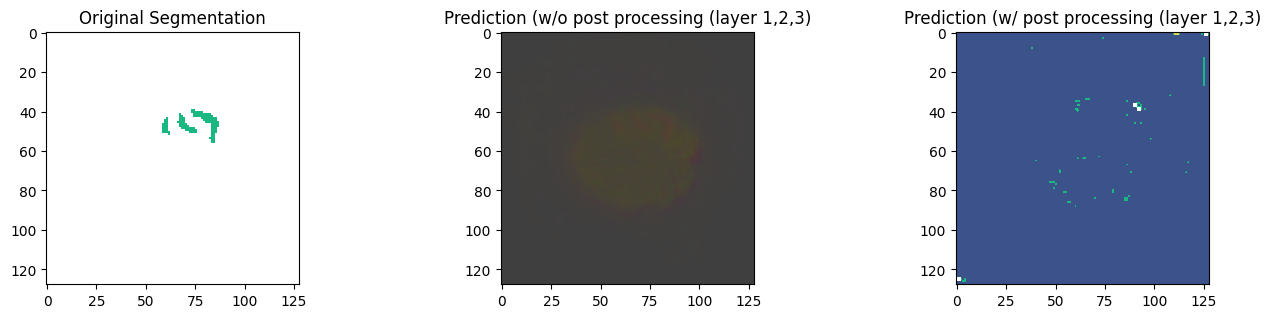

In [40]:
show_post_processed_segmentations(sample = "BraTS-GLI-00777-000", slice_to_plot=60, cmap=cmap, norm=norm)

3/3 [==============================] - 0s 13ms/step
Patient number:  BraTS-GLI-00675-000


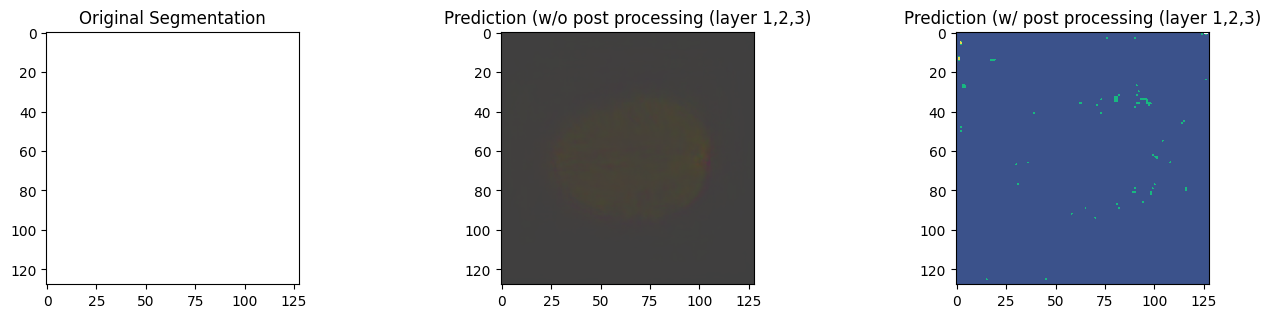

In [41]:
show_post_processed_segmentations(sample = "BraTS-GLI-00675-000", slice_to_plot=50, cmap=cmap, norm=norm)

### Step 6 - Evaluate the model

In [42]:
# Evaluate the model on the test data

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

150/150 [==============================] - 34s 225ms/step - loss: 1.4086 - accuracy: 0.0059 - mean_io_u: 0.3756 - dice_coef: 0.1069 - precision: 0.0229 - sensitivity: 5.7620e-06 - specificity: 0.9996

Model evaluation on the test set:
Loss : 1.4086
Accuracy : 0.0059
MeanIOU : 0.3756
Dice coefficient : 0.1069
Precision : 0.0229
Sensitivity : 0.0
Specificity : 0.9996
